In [1]:
#ld use a generator to load data and preprocess it on the fly, in batch size portions to feed into your Behavioral Cloning model .

import os
import csv

samples = []
with open('mydata/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
with open('second track/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn
from numpy.random import shuffle

def generator(samples, batch_size=32):
    num_samples = len(samples)
    #count = 0
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                name = 'mydata/IMG/'+batch_sample[0].split('\\')[-1]
                center_image = cv2.imread(name)
                if center_image is None:
                    name = 'second track/IMG/'+batch_sample[0].split('\\')[-1]
                center_image = cv2.imread(name)
                #image loading check
                if center_image is None:
                    print("Image loading failed")
                
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                images.append(cv2.flip( center_image, 1 ))    
                angles.append(-center_angle)
            #print(images[0])
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            #count += len(images)
            #print(count)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
#train_count = 0
#test_count = 0
#tgen = generator(train_samples[1:], batch_size=32)
#vgen = generator(validation_samples[1:], batch_size=32)
#for g1, count1 in tgen:
#    train_generator = g1
#    train_count = count1
#for g2, count2 in vgen:
#    validation_generator = g2
#    test_count = count2

train_generator = generator(train_samples[1:], batch_size=32)
validation_generator = generator(validation_samples[1:], batch_size=32)

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras.models import Model
from keras.regularizers import l2, activity_l2
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [3]:
name = 'mydata/IMG/'+samples[1][0].split('\\')[-1]
image = cv2.imread(name)
crop_top = 50
crop_bottom = 20
shape = (image.shape[0]-(crop_top+crop_bottom), image.shape[1], image.shape[2])
print(shape)

(90, 320, 3)


In [4]:
def getLenetModel():
    model = Sequential()
    model.add(Cropping2D(cropping=((crop_top,crop_bottom), (0,0)), input_shape=image.shape))
    model.add(Lambda(lambda x: (x / 127.5) - 1., input_shape=shape))
    model.add(Convolution2D(6, 5, 5,border_mode='valid', activation='elu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(6, 5, 5,border_mode='valid', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(6, 5, 5,border_mode='valid', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(1))
    return model


In [5]:
def getNvidiaModel():
    model = Sequential()
    model.add(Cropping2D(cropping=((crop_top,crop_bottom), (0,0)), input_shape=image.shape))
    model.add(Lambda(lambda x: (x / 127.5) - 1., input_shape=shape))
    model.add(Convolution2D(24, 5, 5,border_mode='valid',subsample=(2,2), activation='elu', W_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(36, 5, 5,border_mode='valid', subsample=(2,2), activation='elu', W_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(48, 3, 3,border_mode='valid', subsample=(2,2), activation='elu', W_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3,border_mode='valid', subsample=(2,2), activation='elu', W_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(2048, W_regularizer=l2(0.001)))
    model.add(Activation('elu'))
    model.add(Dense(256, W_regularizer=l2(0.001)))
    model.add(Activation('elu'))
    model.add(Dense(64, W_regularizer=l2(0.001)))
    model.add(Activation('elu'))
    model.add(Dense(16, W_regularizer=l2(0.001)))
    model.add(Activation('elu'))
    model.add(Dense(1))
    return model

In [6]:
def runModel(model, filename):    
    history_object = model.fit_generator(train_generator, samples_per_epoch =
        len(train_samples), validation_data = 
        validation_generator,
        nb_val_samples = len(validation_samples), 
        nb_epoch=6, verbose=1)

    # Save model data
    model.save_weights(filename+'.h5')
    json_string = model.to_json()
    with open(filename +'.json', 'w') as f:
        f.write(json_string)

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()



Running nvidia model
Epoch 1/20
12160/12184 [============================>.] - ETA: 0s - loss: 2.2747

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


12224/12184 [==============================] - 39s - loss: 2.2688 - val_loss: 1.1723
Epoch 2/20
12206/12184 [==============================] - 38s - loss: 0.7714 - val_loss: 0.5163
Epoch 3/20
12224/12184 [==============================] - 38s - loss: 0.4312 - val_loss: 0.3611
Epoch 4/20
12206/12184 [==============================] - 38s - loss: 0.3306 - val_loss: 0.2905
Epoch 5/20
12224/12184 [==============================] - 38s - loss: 0.2780 - val_loss: 0.2535
Epoch 6/20
12206/12184 [==============================] - 38s - loss: 0.2408 - val_loss: 0.2199
Epoch 7/20
12224/12184 [==============================] - 38s - loss: 0.2190 - val_loss: 0.2068
Epoch 8/20
12206/12184 [==============================] - 38s - loss: 0.1995 - val_loss: 0.1808
Epoch 9/20
12224/12184 [==============================] - 38s - loss: 0.1816 - val_loss: 0.1802
Epoch 10/20
12206/12184 [==============================] - 38s - loss: 0.1709 - val_loss: 0.1616
Epoch 11/20
12224/12184 [=========================

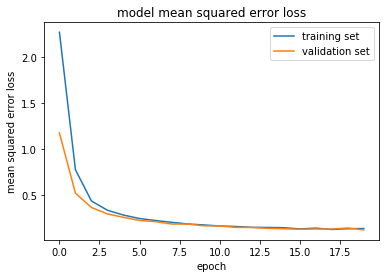

NameError: name 'train_count' is not defined

In [7]:
# run nvidia model
model = getNvidiaModel()
model.compile(loss='mse', optimizer='adam')
print("Running nvidia model")
runModel(model, 'nmodel')

Running lenet model
Epoch 1/20
12160/12184 [============================>.] - ETA: 0s - loss: 0.1164

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


12224/12184 [==============================] - 30s - loss: 0.1163 - val_loss: 0.0922
Epoch 2/20
12206/12184 [==============================] - 29s - loss: 0.0941 - val_loss: 0.0895
Epoch 3/20
12224/12184 [==============================] - 29s - loss: 0.0831 - val_loss: 0.0866
Epoch 4/20
12206/12184 [==============================] - 29s - loss: 0.0830 - val_loss: 0.0788
Epoch 5/20
12224/12184 [==============================] - 29s - loss: 0.0707 - val_loss: 0.0773
Epoch 6/20
12206/12184 [==============================] - 29s - loss: 0.0709 - val_loss: 0.0742
Epoch 7/20
12224/12184 [==============================] - 29s - loss: 0.0622 - val_loss: 0.0719
Epoch 8/20
12206/12184 [==============================] - 29s - loss: 0.0614 - val_loss: 0.0754
Epoch 9/20
12224/12184 [==============================] - 29s - loss: 0.0518 - val_loss: 0.0773
Epoch 10/20
12206/12184 [==============================] - 30s - loss: 0.0539 - val_loss: 0.0696
Epoch 11/20
12224/12184 [=========================

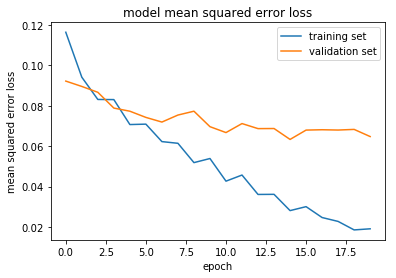

In [8]:
# run lenet model
model1 = getLenetModel()
model1.compile(loss='mse', optimizer='adam')
print("Running lenet model")
runModel(model1, 'lmodel')